In [ ]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [ ]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

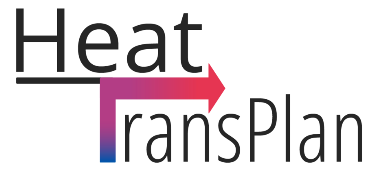


<div style="text-align: center; font-size: 50px;">
    <b>Energy and Sensor mapping on Process Data</b>
</div>

## Index
- [Define Paths and Load Datasets](#define-paths-and-load-datasets)
    - [Define Paths](#define-paths)
    - [Load Datasets](#load-datasets)
    - [Data Transformation and Cleaning](#data-transformation-and-cleaning)
- [Merge Datasets](#merge-datasets)
- [Map Process Data to Energy and Sensor Data](#map-process-data-to-energy-data-and-sensor-data)
- [Map Energy Data to Activities](#map-energy-data-to-activities)
    - [Map Electricity & Steam to each Activity](#map-electricity--steam-to-each-activity)
        - [Electricity](#electricity)
        - [Steam](#steam)
    - [Calculate Electricity and Steam Consmption for the whole Process](#calculate-electricity-and-steam-consumption-for-the-whole-process)
- [Merge Sensor Data](#merge-sensor-data)
    - [Merge Sensor Data on Activity Level](#merge-sensor-data-on-activity-level)
    - [Merge Sensor Data on Process Level](#merge-sensor-data-on-process-level)


In [ ]:
import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
from pathlib import Path
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Define Paths and Load Datasets

## Define Paths

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_raw = current_path.parent.parent.parent.parent / 'data' / 'raw' / 'eckes_granini'

In [ ]:
files_folder_raw

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_bronze = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/silver/aixit' folder relative to the current path
files_folder_silver = current_path.parent.parent.parent.parent / 'data' / 'silver' / 'eckes_granini'

## Load Datasets

In [ ]:
# load Aufträge PET2 08_2024
df_orders = pd.read_excel(files_folder_raw/"Aufträge Energie Meldungen/Aufträge PET2 08_2024.xlsx", header=1, parse_dates=["StartTime", "EndTime"])
print(df_orders.columns)

df_orders.head()

In [ ]:
# load Meldungen PET2 KZE 08_2024
df_activities = pd.read_excel(files_folder_raw/"Aufträge Energie Meldungen/Meldungen PET2 KZE 08_2024.xlsx", header=2, parse_dates=["Aufgetreten", "Gegangen"])
print(df_activities.columns)

df_activities.head()

In [ ]:
# load Energie Gesamtwerte
# Strom in kWh und Dampf in kg
df_energy_total = pd.read_excel(files_folder_raw/"Aufträge Energie Meldungen/Energie Gesamtwerte PET2 KZE 08_2024.xlsx", header=0, parse_dates=["Datum / Uhrzeit"])
print(df_energy_total.columns)

df_energy_total.head()

In [ ]:
# load Energie Istwerte
# Strom in kW und Dampf in kg/h
df_energy_ist = pd.read_excel(files_folder_raw/"Aufträge Energie Meldungen/Energie Istwerte PET2 KZE 08_2024.xlsx", header=0, parse_dates=["Datum / Uhrzeit"])
print(df_energy_ist.columns)

df_energy_ist.head()

In [ ]:
#load sensor data
df_sensor = pd.read_parquet(files_folder_bronze / 'df_sensor_joined.parquet')
df_sensor

## Data Transformation and Cleaning

In [ ]:
#transform Objektbezeichnungen as PET 2 and PET is the same and we can eliminate them
words = ["PET 2", "PET"]

for w in words:
    df_activities["Objektbezeichnung"] = df_activities["Objektbezeichnung"].str.replace(w, "", regex=False)

df_activities["Objektbezeichnung"] = df_activities["Objektbezeichnung"].str.strip()

In [ ]:
#drop every Objektbezeichnung except Erhitzer
df_activities = df_activities[df_activities["Objektbezeichnung"] == "Erhitzer"]

In [ ]:
df_activities.head()

# Merge Datasets

### Merge Orders and Activities

In [ ]:
#mapping data according to timestamps
# Funktion zum Mapping
def map_order(row, orders_df):
    matched_order = orders_df[
        (orders_df["StartTime"] <= row["Aufgetreten"]) & 
        (orders_df["EndTime"] >= row["Gegangen"])
    ]
    return matched_order.iloc[0]["OrderNumber"] if not matched_order.empty else None

# Mapping durchführen
df_activities["OrderNumber"] = df_activities.apply(map_order, orders_df=df_orders, axis=1)

# DataFrames zusammenführen
df_orders_activities = pd.merge(df_orders, df_activities, on="OrderNumber", how="left", suffixes=("_Order", "_Activity"))

#merge Objektbezeichnung and Kommende Meldung so that we can use it as Activity Name in the sense of Process Mining
df_orders_activities["ActivityName"] = df_orders_activities["Objektbezeichnung"] + " " + df_orders_activities["Kommende Meldung"]

#rename columns to differentiate between Timestamps of total order and the single activities
df_orders_activities = df_orders_activities.rename(columns={"StartTime": "StartTime_Order", "EndTime": "EndTime_Order", "Aufgetreten": "StartTime_Activity", "Gegangen": "EndTime_Activity"})

#sort according to timestamp StartTime_Activity
df_orders_activities = df_orders_activities.sort_values(by="StartTime_Activity")

#transform and clean
df_orders_activities = df_orders_activities.drop(columns=["Unnamed: 8"])
df_orders_activities = df_orders_activities.dropna(subset=["StartTime_Activity"])

# Ergebnis speichern
df_orders_activities.to_csv(files_folder_bronze/"AufträgeMeldungen_merged.csv", index=False)

In [ ]:
df_orders_activities.head()

In [ ]:
#sich überlappende Aktivitäten anzeigen

df = df_orders_activities.copy()

# Nach Order und Startzeit sortieren
df = df.sort_values(["OrderNumber", "StartTime_Activity"])

# Pro Order die nächste Startzeit "daneben legen"
df["Next_Start"] = df.groupby("OrderNumber")["StartTime_Activity"].shift(-1)

# Überschneidung, wenn: Ende der aktuellen Aktivität > Start der nächsten
df["Overlap_with_next"] = df["EndTime_Activity"] > df["Next_Start"]

# Alle Zeilen, bei denen eine Überschneidung auftritt
overlaps = df[df["Overlap_with_next"] == True]

print(overlaps)

problem = df[df["Overlap_with_next"]].copy()

# zur Info die nächste Aktivität dazuholen
problem["Next_ActivityName"] = df.groupby("OrderNumber")["ActivityName"].shift(-1)
problem["Next_End"] = df.groupby("OrderNumber")["EndTime_Activity"].shift(-1)

problem[[
    "OrderNumber",
    "ActivityName",
    "StartTime_Activity",
    "EndTime_Activity",
    "Next_ActivityName",
    "Next_Start",
    "Next_End"
]]

### Merge Energy Ist and Sensor Data (5 Sek interval)

In [ ]:
df_energy_ist["ts"] = pd.to_datetime(df_energy_ist["Datum / Uhrzeit"])
df_energy_ist = df_energy_ist.sort_values("ts")

df_sensor["ts"] = pd.to_datetime(df_sensor["datetime"])
df_sensor = df_sensor.sort_values("ts")

df_energy_sensor = pd.merge_asof(
    df_energy_ist,
    df_sensor.drop(columns=["datetime"], errors="ignore"),
    on="ts",
    direction="nearest",
)

df_energy_sensor

# Map Process Data to Energy Data and Sensor Data

In [ ]:
# map process data to energy data

df_act = df_orders_activities.sort_values("StartTime_Activity")

act_cols = [
    "OrderNumber", "BF Product", "BF Number", "ActualQuantity",
    "StartTime_Order", "EndTime_Order",
    "ActivityName", "StartTime_Activity", "EndTime_Activity",
    "Objektbezeichnung", "Kommende Meldung"
]

tmp = pd.merge_asof(
    df_energy_sensor,
    df_act[act_cols],
    left_on="ts",
    right_on="StartTime_Activity",
    direction="backward"
)

# gültig nur wenn ts innerhalb des Aktivitätsintervalls liegt
mask_valid = tmp["EndTime_Activity"].notna() & (tmp["ts"] <= tmp["EndTime_Activity"])

# wenn ungültig: ALLE Prozessspalten leeren
tmp.loc[~mask_valid, act_cols] = None

df_energy_sensors_process_5s = tmp

df_energy_sensors_process_5s = tmp.drop(columns=["ts"])
df_energy_sensors_process_5s = df_energy_sensors_process_5s.rename(
    columns={"Datum / Uhrzeit": "datetime"}
)

df_energy_sensors_process_5s.to_csv(files_folder_silver/"Aufträge_Energy_Sensor_merged.csv", index=False)

df_energy_sensors_process_5s.head()


# Map Energy Data to Activities

In [ ]:
df_orders_activities_energy = df_orders_activities

# Dauer einzelner Aktivitäten berechnen
df_orders_activities_energy["dauer_activity_s"] = (df_orders_activities_energy["EndTime_Activity"] - df_orders_activities_energy["StartTime_Activity"]).dt.total_seconds()
df_orders_activities_energy["dauer_activity_h"] = df_orders_activities_energy["dauer_activity_s"] / 3600

## Map Electricity & Steam to each Activity

### Electricity

In [ ]:
# Berechnung der momentanten Stromleistung für jede Aktivität
# Energie aus 5-Sekunden-Leistungswerten berechnen
# Annahme: "Strom aktuell PET2 KZE" ist Leistung in kW
# Energie für jedes 5-Sekunden intervall ist in kWh
MESS_INTERVALL_S = 5  # Sekunden
df_energy_ist["Strom_kWh"] = df_energy_ist["Strom aktuell PET2 KZE"] * (MESS_INTERVALL_S / 3600)

# Funktion: Energie für eine Aktivität (Start/Ende) aufsummieren
def energy_for_activity(row):
    start = row["StartTime_Activity"]
    end   = row["EndTime_Activity"]
    
    # alle Messpunkte, die in das Aktivitätsfenster fallen
    mask = (df_energy_ist["Datum / Uhrzeit"] >= start) & (df_energy_ist["Datum / Uhrzeit"] < end)
    
    # kWh über dieses Zeitfenster aufsummieren
    return df_energy_ist.loc[mask, "Strom_kWh"].sum()

# Auf alle Aktivitäten anwenden
df_orders_activities_energy["Strom_kWh"] = df_orders_activities_energy.apply(energy_for_activity, axis=1)

In [ ]:
# Berechnung der tatsächlich verbrauchten Menge an Strom pro Aktivität
df_orders_activities_energy["Strom_kW"] = df_orders_activities_energy["Strom_kWh"] / df_orders_activities_energy["dauer_activity_h"]

In [ ]:
print(df_orders_activities_energy[
    ["ActivityName", "Strom_kWh", "Strom_kW", "dauer_activity_h"]
])

### Steam

In [ ]:
# Energie aus 5-Sekunden-Leistungswerten berechnen
# Annahme: "Dampf aktuell PET2 KZE 30120FT801" ist Leistung in kg/h
MESS_INTERVALL_S = 5  # Sekunden
df_energy_ist["Dampf_kg"] = df_energy_ist["Dampf aktuell PET2 KZE 30120FT801"] * (MESS_INTERVALL_S / 3600)

# Funktion: Energie für eine Aktivität (Start/Ende) aufsummieren
def energy_for_activity(row):
    start = row["StartTime_Activity"]
    end   = row["EndTime_Activity"]
    
    # alle Messpunkte, die in das Aktivitätsfenster fallen
    mask = (df_energy_ist["Datum / Uhrzeit"] >= start) & (df_energy_ist["Datum / Uhrzeit"] < end)
    
    # kWh über dieses Zeitfenster aufsummieren
    return df_energy_ist.loc[mask, "Dampf_kg"].sum()


# Auf alle Aktivitäten anwenden
df_orders_activities_energy["Dampf_kg"] = df_orders_activities_energy.apply(energy_for_activity, axis=1)

In [ ]:
# Berechnung der tatsächlich verbrauchten Menge an Dampf pro Aktivität
df_orders_activities_energy["Dampf_kg_h"] = df_orders_activities_energy["Dampf_kg"] / df_orders_activities_energy["dauer_activity_h"]

In [ ]:
df_orders_activities_energy

In [ ]:
df_orders_activities_energy.to_csv(files_folder_bronze/"AufträgeMeldungen_Activities_Energy_merged.csv", index=False)

## Calculate Electricity and Steam Consumption for the whole Process

In [ ]:
# Gruppierung nach OrderNumber
group_cols = ["OrderNumber"] 

df_orders_energy = (
    df_orders_activities_energy
    .groupby(group_cols)
    .agg(
        Product = ("BF Product", "min"),
        Strom_kWh_total = ("Strom_kWh", "sum"),
        Dampf_kg_total  = ("Dampf_kg", "sum"),
        Start_Prozess   = ("StartTime_Order", "min"),
        Ende_Prozess    = ("EndTime_Order", "max"),
    )
    .reset_index()
)

# Prozessdauer in Stunden berechnen (optional für Durchschnittswerte)
df_orders_energy["Prozessdauer_h"] = (
    df_orders_energy["Ende_Prozess"] - df_orders_energy["Start_Prozess"]
).dt.total_seconds() / 3600

# Durchschnittliche Leistungen über den ganzen Prozess (optional)
df_orders_energy["Strom_kW_avg"]   = df_orders_energy["Strom_kWh_total"] / df_orders_energy["Prozessdauer_h"]
df_orders_energy["Dampf_kg_h_avg"] = df_orders_energy["Dampf_kg_total"]   / df_orders_energy["Prozessdauer_h"]

df_orders_energy = df_orders_energy.sort_values(by="Start_Prozess")
df_orders_energy

In [ ]:
df_orders_energy.to_csv(files_folder_bronze/"AufträgeMeldungen_Orders_Energy_merged.csv", index=False)

# Merge Sensor Data

In [ ]:
#create new dataframe with process information and sensor data and energy data
df_orders_activities_energy_sensor = df_orders_activities_energy

## Merge Sensor Data on Activity Level

In [ ]:
list(df_sensor.columns)

In [ ]:
# 1. Funktion: Sensordaten über eine Aktivitätsdauer mitteln
def sensor_for_activity(row, col):
    start = row["StartTime_Activity"]
    end   = row["EndTime_Activity"]

    # alle Messpunkte innerhalb des Aktivitätsfensters
    mask = (df_sensor["datetime"] >= start) & (df_sensor["datetime"] < end)

    # Mittelwert der gewünschten Sensor-Spalte
    return df_sensor.loc[mask, col].mean()


# 2. Liste aller Sensor-Spalten, die du auswerten möchtest
sensor_cols = [ 'temp_Auslauf_EG_(WT2)_5s',
 'temp_Einlauf_EG_(WT_2)_5s',
 'flow_Kuehlturmwasser_30120FT701_5s',
 'flow_Kaltwasser_(WT7)_5s',
 'Kuehlturmwassertemp_(WT6)_5s',
 'Kaltwassertemp_(WT_7)_5s',
 'nach_Kuehler_(WT7)_5s',
 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
 'Fuellstand_Steriltank_30140LT001_5s',
 'Fuellstand_Steriltank_30141LT001_5s',
 'flow_Dampf_WT3a/5a)_5s',
 'flow_Heisswasser_30120FT721(WT5a)_5s',
 'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
 'temp_nach_Erhitzer_(WT5)_5s',
 'temp_nach_WR2_(WT2)_5s',
 'temp_nach_Austauscher_2_(WT4)_5s',
 'Druck_HW_Anwaermer_(WT3a)_5s',
 'temp_HW_Anwaermer_(WT3a)_5s',
 'temp_Produkt_Einlauf_30110TT001_1h',
 'flow_Vorlaufpumpe_30110FT301_1h',
 'temp_vor_Vorwärmer_(WT_2)_1h']


# 3. Mittelwerte je Aktivität berechnen und als neue Spalten anhängen
for col in sensor_cols:
    new_col_name = col.replace("_5s", "_mean").replace("_1h", "_mean")  # oder anderer Name
    df_orders_activities_energy_sensor[new_col_name] = df_orders_activities_energy_sensor.apply(
        sensor_for_activity,
        axis=1,
        col=col
    )

In [ ]:
df_orders_activities_energy_sensor.head()

In [ ]:
df_orders_activities_energy_sensor.to_csv(files_folder_silver/"AufträgeMeldungen_Activities_Energy_Sensor_merged.csv", index=False)

## Merge Sensor Data on Process Level

In [ ]:
#get list of columns
list(df_orders_activities_energy_sensor.columns)

In [ ]:
# 1) Alle Spaltennamen automatisch holen
cols = df_orders_activities_energy_sensor.columns

# 2) Alle Sensor-Spalten finden, die auf "_mean" enden
mean_cols = [c for c in cols if c.endswith("_mean")]

# 3) Aggregations-Definition für groupby bauen
group_cols = ["OrderNumber"]

agg_dict = {
    "Product": ("BF Product", "min"),
    "Start_Prozess": ("StartTime_Order", "min"),
    "Ende_Prozess": ("EndTime_Order", "max"),
    "Strom_kWh_total": ("Strom_kWh", "sum"),
    "Dampf_kg_total": ("Dampf_kg", "sum"),
}

# Für alle *_mean-Spalten: noch einmal den Mittelwert über den gesamten Prozess bilden
# -> neue Spaltennamen optional ohne "_mean"
for c in mean_cols:
    new_name = c.replace("_mean", "")  # oder lass einfach c, wenn du den Namen behalten willst
    agg_dict[new_name] = (c, "mean")

# 4) Gruppierung nach OrderNumber und Aggregation
df_orders_energy_sensor = (
    df_orders_activities_energy_sensor
    .groupby(group_cols)
    .agg(**agg_dict)
    .reset_index()
)

# Prozessdauer in Stunden berechnen (optional für Durchschnittswerte)
df_orders_energy_sensor["Prozessdauer_h"] = (
    df_orders_energy_sensor["Ende_Prozess"] - df_orders_energy_sensor["Start_Prozess"]
).dt.total_seconds() / 3600

# Durchschnittliche Leistungen über den ganzen Prozess (optional)
df_orders_energy_sensor["Strom_kW_avg"]   = df_orders_energy_sensor["Strom_kWh_total"] / df_orders_energy_sensor["Prozessdauer_h"]
df_orders_energy_sensor["Dampf_kg_h_avg"] = df_orders_energy_sensor["Dampf_kg_total"]   / df_orders_energy_sensor["Prozessdauer_h"]

df_orders_energy_sensor = df_orders_energy_sensor.sort_values(by="Start_Prozess")
df_orders_energy_sensor.head()

In [ ]:
df_orders_energy_sensor.to_csv(files_folder_silver/"AufträgeMeldungen_Orders_Energy_Sensor_merged.csv", index=False)